# <span style="color:red">Preparing Textual Data for Statistics and Machine Learning</span>

We will be using the reddit self posts available in Kaggle

In [4]:
import pandas as pd

posts_file = "C:\\Users\\nzaye\\Desktop\\Machine_learning\\data\\reddit\\rspct.tsv"
posts_df = pd.read_csv(posts_file, sep='\t')

subred_file = "C:\\Users\\nzaye\\Desktop\\Machine_learning\\data\\reddit\\subreddit_info.csv"
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

df = posts_df.join(subred_df, on='subreddit')

In [5]:
df.columns

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')

In [6]:
df.head()

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,NaN,True,NaN
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,NaN,True,NaN
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,NaN,True,NaN
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,NaN,True,NaN
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,intel,True,NaN


### **Blueprint: Standardizing Attribute Names**

Before we start working with the data, we will change the dataset-specific column names to more generic names. We recommend always naming the main DataFrame df, and naming the column with the text to analyze text. Such naming conventions for common variables and attribute names make it
easier to reuse the code of the blueprints in different projects.

For column renaming and selection, we define a dictionary column_mapping where each entry defines a mapping from the current column name to a new name. Columns mapped to None and unmentioned columns are dropped. A dictionary is perfect documentation for such a transformation and easy to reuse. This dictionary is then used to select and rename the columns that we want to keep.

In [8]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',
    'category_3': None, # no data
    'in_data': None, # not needed
    'reason_for_exclusion': None # not needed
}

# define remaning columns:
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# select and remove those columns:
df = df[columns].rename(columns=column_mapping)

In [9]:
df.columns

Index(['id', 'subreddit', 'title', 'text', 'category', 'subcategory'], dtype='object')

In [10]:
df.sample(1)

,id,subreddit,title,text,category,subcategory
332921,8j1n1r,Tinder,Does changing gender preference effect your pr...,I've always dated women but I'm opening myself...,company/website,online dating


In [11]:
df.sample(1).T

,495150
id,75zanc
subreddit,cigars
title,Trade with /u/gdalam proves I need to step up ...
text,I'm totally blown away! Just got a package fro...
category,drugs
subcategory,tobacco


### Saving the dataframe in a SQLITE database 

In [28]:
import sqlite3

db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df.to_sql('posts', con, index=False, if_exists="replace")
con.close()

In [29]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

## Cleaning Text Data

### **Blueprint: Identify Noise with Regular Expressions**

The idea is to set up some metrics to describe the quality of text with regards to the noise (e.g.: html tags...).

In [13]:
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')


def impurity(text, min_len=10):
    
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [30]:
# add new column to data frame
df['impurity'] = df['text'].apply(impurity, min_len=10)

In [31]:
# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,text,impurity
513243,"Here's all of their singles, so none of these ...",0.302914
966949,"I think it might just be gibberish, but I want...",0.292324
421581,I find if you search using terms related to th...,0.289977


**Function count_words from Chapter One**

In [32]:
from collections import Counter

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
        
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [33]:
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

,freq
token,
<lb>,6753605
<tab>,95917


Now we know that although these two tags are common, they are the only ones.

### **Blueprint: Removing Noise with Regular Expressions**

In [34]:
import html

def clean(text):
    
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [35]:
df['clean_text'] = df['text'].map(clean)

In [37]:
df.sample()

,id,subreddit,title,text,category,subcategory,impurity,clean_text
660720,89ac2u,Meditation,Trouble visualizing white light,"Hi, I've recently been trying to do a lot of m...",health,mindfulness/meditation,0.01766,"Hi, I've recently been trying to do a lot of m..."


In [39]:
# Calculating the impurity of the clean text
df['impurity'] = df['clean_text'].apply(impurity, min_len=20)

In [40]:
df.head()

,id,subreddit,title,text,category,subcategory,impurity,clean_text
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,0.0,"Hi there, The usual. Long time lerker, first t..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,0.0,Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,0.0,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,0.0,I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,0.0,"Prime95 (regardless of version) and OCCT both,..."


In [41]:
df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,clean_text,impurity
901234,I've ran our site through multiple scanners an...,0.223554
818363,Please use this form to post custom cipher sol...,0.202572
825981,I have used the preclear plugin before without...,0.179025


## **Blueprint: Character Normalization with textacy**

Accented characters can be a problem because people do not consistently use them. For example, the tokens Saint-Raphaël and Saint-Raphael will not be recognized as identical. In addition, texts often contain words separated by a hyphen due to the automatic line breaks. Fancy Unicode hyphens and apostrophes like the ones used in the text can be a problem for tokenization. For all of these issues it makes sense to normalize the text and replace accents and fancy characters with ASCII equivalents.

In [ ]:
pip install textacy

In [45]:
import textacy.preprocessing as tprep


def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [46]:
sometext = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

print(normalize(sometext))

The cafe "Saint-Raphael" is located on Cote d'Azur.


>As Unicode normalization has many facets, you can check out other libraries. unidecode, for example, does an excellent job here.

## **Blueprint: Pattern-Based Data Masking with textacy**

In [48]:
from textacy.preprocessing.resources import RE_URL

count_words(df, column='clean_text', preprocess=RE_URL.findall).head(5)

,freq
token,
https://keybase.io/crypto,275
www.pokemon.com/TCGO,49
www.google.com,38
www.reddit.com,32
https://battlescribe.net,29


For the analysis we want to perform with this dataset (in Chapter 10), we are not interested in those URLs. They rather represent a disturbing artifact. Thus, we will substitute all URLs in our text with replace_urls

In [56]:
from textacy.preprocessing.replace import urls

sometext = "Check out https://spacy.io/usage/spacy-101"
# using default substitution _URL_
print(urls(sometext))

Check out _URL_


In [58]:
df['clean_text'] = df['clean_text'].map(urls)

In [59]:
df.head(5)

,id,subreddit,title,text,category,subcategory,impurity,clean_text
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,0.0,"Hi there, The usual. Long time lerker, first t..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,0.0,Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,0.0,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,0.0,I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,0.0,"Prime95 (regardless of version) and OCCT both,..."


In [60]:
df['clean_text'] = df['clean_text'].map(normalize)

We finally rename the text columns so that clean_text becomes text, drop the impurity column, and store the new version of the DataFrame in the database.

In [61]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)

In [62]:
df.head()

,id,subreddit,title,raw_text,category,subcategory,impurity,text
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,0.0,"Hi there, The usual. Long time lerker, first t..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,0.0,Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,0.0,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,0.0,I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,0.0,"Prime95 (regardless of version) and OCCT both,..."


In [63]:
df.drop(columns=['impurity'], inplace=True)

In [64]:
df.head()

,id,subreddit,title,raw_text,category,subcategory,text
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,"Hi there, The usual. Long time lerker, first t..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,"Prime95 (regardless of version) and OCCT both,..."


Saving in the database

In [65]:
con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

## **Linguistic Processing with spaCy**

**Instantiating a Pipeline**

As a first step we need to instantiate an object of spaCy’s Language class by calling spacy.load() along with the name of the model file to use

In [69]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [70]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1ad9433fe80>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1adac4a3ca0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1ae526cbd80>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1aea673d500>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1aea67784c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1ae526cbf40>)]

**Utility function: display_nlp to generate a table containing the tokens and their attributes.**

In [71]:
def display_nlp(doc, include_punct=False):
    
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    
    for i, t in enumerate(doc):
        
        if not t.is_punct or include_punct:
            row = {'token': i, 'text': t.text, 'lemma_': t.lemma_, 'is_stop': t.is_stop, 
                   'is_alpha': t.is_alpha, 'pos_': t.pos_, 'dep_': t.dep_,
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
            
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [72]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [73]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


## **Blueprint: Customizing Tokenization**

Tokenization is the first step in the pipeline. spaCy’s tokenizer does a good job in most cases, but it splits on hash signs, hyphens, and underscores, which is sometimes not what you want. Therefore, it may be necessary to adjust its behavior. Example:

In [74]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

The best approach for this is to create your own variant of the tokenizer with individual rules for infix, prefix, and suffix splitting.

In [77]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

In [78]:
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

## **Blueprint: Working with Stop Words**

In [80]:
# Example
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

In [82]:
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


The list of English stop words with more than 300 entries can be accessed by importing spacy.lang.en.STOP_WORDS. When an nlp object is created, this list is loaded and stored under nlp.Defaults.stop_words. We can modify spaCy’s default behavior by setting the is_stop property of the respective words in spaCy’s vocabulary:

In [83]:
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regards'].is_stop = True

In [85]:
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Ryan, need, sit, down, talk, Pete]


## **Blueprint: Extracting Lemmas Based on Part of Speech**

In [86]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
print(*[t.lemma_ for t in doc], sep=' | ')

my | good | friend | Ryan | Peters | like | fancy | adventure | game | .


The correct assignment of the lemma requires a lookup dictionary and knowledge about the part of speech of a word. For example, the lemma of the noun meeting is meeting, while the lemma of the verb is meet. In English, spaCy is able to make this distinction. In most other languages, however, lemmatization is purely dictionary-based, ignoring the part-of-speech dependency.

Part-of-speech tags are an excellent alternative to stop words as word filters. In linguistics, pronouns, prepositions, conjunctions, and determiners are called function words because their main function is to create grammatical relationships within a sentence. Nouns, verbs, adjectives, and adverbs are content words, and the meaning of a sentence depends mainly on them.

Often, we are interested only in content words. Thus, instead of using a stop word list, we can use part-of-speech tags to select the word types we are interested in and discard the rest. For example, a list containing only the nouns and proper nouns in a doc can be generated like this:

In [87]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


The following example shows how to extract tokens for adjectives and nouns from the sample sentence:

In [88]:
import textacy

tokens = textacy.extract.words(doc,
            filter_stops = True, # default True, no stopwords
            filter_punct = True, # default True, no punctuation
            filter_nums = True, # default False, no numbers
            include_pos = ['ADJ', 'NOUN'], # default None = include all
            exclude_pos = None, # default None = exclude none
            min_freq = 1) # minimum frequency of words

print(*[t for t in tokens], sep=' | ')

best | friend | fancy | adventure | games


**Blueprint function to extract a filtered list of word lemmas**

In [89]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

In [90]:
# Example:
lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


## **Blueprint: Extracting Noun Phrases**

Many bigrams are not very useful for analysis, for example, likes_fancy or my_best. It would be even worse for trigrams. But how can we detect word sequences that have real meaning? One way is to apply pattern-matching on the part-of-speech tags.

In [92]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]

spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


**We define our blueprint function for noun phrase extraction based on part-of-speech patterns.**

In [93]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    
    return [sep.join([t.lemma_ for t in s]) for s in spans]

In [94]:
print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


## **Blueprint: Extracting Named Entities**

Named-entity recognition refers to the process of detecting entities such as people, locations, or organizations in text. Each entity can consist of one or more tokens, like San Francisco.

In [98]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)
for ent in doc.ents:
    print(f"{ent.text}: {ent.label_}", end="\n")

James O'Neill: PERSON
World Cargo Inc: ORG
San Francisco: GPE


In [99]:
from spacy import displacy
displacy.render(doc, style='ent')

For the extraction of named entities of certain types, we again make use of one of textacy’s convenient functions:

In [102]:
def extract_entities(doc, include_types=None, sep='_'):
    
    ents = textacy.extract.entities(doc, include_types=include_types, exclude_types=None, 
                                    drop_determiners=True, min_freq=1)
    
    return [sep.join([t.lemma_ for t in e]) + '/' + e.label_ for e in ents]

In [103]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


# **Feature Extraction on a Large Dataset**

## **Blueprint: Creating One Function to Get It All**

This blueprint function combines all the extraction functions from the previous section. It neatly puts everything we want to extract in one place in the code so that the subsequent steps do not need to be adjusted if you add or change something here:

In [105]:
def extract_nlp(doc):
    return { 
        'lemmas' : extract_lemmas(doc, 
                                  exclude_pos = ['PART', 'PUNCT', 
                                                 'DET', 'PRON', 'SYM', 'SPACE'],
                                  filter_stops = False),
        'adjs_verbs' : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases' : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
        'entities' : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [106]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [107]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


## **Blueprint: Using spaCy on a Large Dataset**

In [108]:
db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts_cleaned", con)
con.close()

In [109]:
df['text'] = df['title'] + ': ' + df['text']

In [110]:
df.head()

,id,subreddit,title,raw_text,category,subcategory,text
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,Remember your command line switches...: Hi the...
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,"So what was Matt ""addicted"" to?: Did he ever s..."
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,No Club Colors: Funny story. I went to college...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,"Not door bell, but floodlight mount height.: I..."
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,Worried about my 8700k small fft/data stress r...


Before we start NLP processing, we initialize the new DataFrame columns we want to fill with values:

In [111]:
for col in nlp_columns:
    df[col] = None

spaCy’s neural models benefit from running on GPU. Thus, we try to load the model on the GPU before we start:

In [112]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


Now we have to decide which model and which of the pipeline components to use. Remember to disable unneccesary components to improve runtime! We stick to the small English model with the default pipeline and use our custom tokenizer that splits on hyphens:

In [113]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional

When processing larger datasets, it is recommended to use spaCy’s batch processing for a significant performance gain

The function nlp.pipe takes an iterable of texts, processes them internally as a batch, and yields a list of processed Doc objects in the same order as the input data.
To use it, we first have to define a batch size. Then we can loop over the batches and call nlp.pipe.

In [ ]:
batch_size = 50

for i in range(0, len(df), batch_size):
    
    docs = nlp.pipe(df['text'][i:i+batch_size])

    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

In [117]:
df.head()

,id,subreddit,title,raw_text,category,subcategory,text,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,Remember your command line switches...: Hi the...,"[remember, command, line, switch, hi, there, u...","[remember, usual, long, kind, right, independe...","[command, line, switch, time, lerker, time, po...","[command_line, command_line_switch, line_switc...","[long_time, long_time_lerker, first_time, firs...","[popularversioncontrol/PERSON, beta1/PERSON, d..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,"So what was Matt ""addicted"" to?: Did he ever s...","[so, be, Matt, addict, to, do, ever, say, addi...","[addict, chug, talk, sober, edit, add, know, d...","[Matt, addiction, beer, addict, addict, group,...",[],[],"[Matt/PERSON, NA/ORG]"
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,No Club Colors: Funny story. I went to college...,"[Club, Colors, funny, story, go, to, college, ...","[funny, go, know, motorcycle, end, call, worth...","[Club, Colors, story, college, Las, Vegas, col...","[college_buddy, dance_club]","[funny_story, front_door, bright_color, much_b...","[Club_Colors_:/ORG, Las_Vegas/GPE, Hogs_Heifer..."
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,"Not door bell, but floodlight mount height.: I...","[door, bell, but, floodlight, mount, height, k...","[know, exist, drop, high, mount, say, ideal, m...","[door, bell, floodlight, mount, height, sub, R...","[door_bell, ground_level]",[],[Floodlight/ORG]
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,Worried about my 8700k small fft/data stress r...,"[worried, about, 8700k, small, fft, datum, str...","[worried, small, small, include, shoot, pure, ...","[fft, datum, stress, result, Prime95, version,...","[datum_stress, datum_stress_result, stress_res...","[small_fft, pure_stock, other_stress, other_st...","[Prime95/PERSON, OCCT/ORG, P95/ORG]"


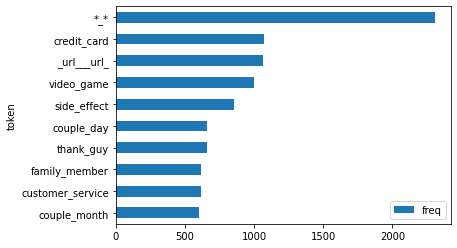

In [123]:
count_words(df, 'noun_phrases').head(10).plot(kind='barh').invert_yaxis()

**Saving the result in the database**

Cannot save due to unsupported type.